# 一、实验介绍

## 1. 实验内容

本实验从波士顿数据集加载数据，提取数据的头部信息和描述内容，进行数据清洗与预处理，最后通过可视化展示数据的统计特征和关系。

## 2. 实验要点

- 掌握如何使用pandas进行数据清洗、处理与分析。
- 学习如何进行特征工程，处理数值型和分类特征。
- 掌握pandas中的分组、聚合和数据透视表的使用。
- 学会使用pandas进行数据转换、合并与连接。
- 探索高级pandas技巧，如自定义聚合函数和复杂数据筛选。


## 3. 实验环境
- Python 3.10.16
- numpy 1.26.4
- pandas 2.2.3
- matplotlib 3.10.0
- seaborn 0.13.2

# 二、实验步骤

## 2.1 加载数据集

1. 导入必要的库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

> 自 1.2 版起，scikit-learn 已删除了 `load_boston`。

>波士顿住房价格数据集存在道德问题：正如
>[1]中的调查，该数据集的作者设计了一个不可反转的变量 “B”。
>非可逆变量 “B”，假设种族自我隔离对房价有积极影响[2]。
>对房价有积极影响[2]。
>此外，创建该数据集的研究目标是研究空气质量对房价的影响。
>空气质量的影响，但并没有充分证明这一假设的正确性。
>这一假设的有效性。

> [1] M Carlisle."Racist data destruction?"<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

>[2] Harrison Jr, David, and Daniel L. Rubinfeld."Hedonic housing prices and the demand for clean air."Journal of environmental economics and management 5.1 (1978): 81-102.<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>

2. 加载波士顿房价数据集

通过数据集原文件直接加载波士顿房价数据集。通过提取文件指定行信息获得数据内容，其中data是特征矩阵，target是目标变量。

In [2]:
data_file="boston"
data_url = data_file if os.path.exists(data_file) else "http://lib.stat.cmu.edu/datasets/boston"
header_and_desc = [ line.strip() for line in open(data_url, encoding="utf-8").readlines()[7:21]]
headers, descs = zip(*[item.split(maxsplit=1) for item in header_and_desc])

In [3]:
raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

通过DataFrame组成df对象便于后续实验的数据处理和分析过程。

In [4]:
boston_df = pd.DataFrame(data, columns=np.array(headers[:-1]).flatten())
boston_df['PRICE'] = target
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## 2.2 数据清洗

- 检查缺失值：通过`isnull()`和`sum()`检查数据的缺失情况。
- 处理异常值：我们将对一些特征进行异常值处理（例如，通过IQR方法处理RM和AGE列的异常值）。
- 特征缩放：对于一些数值型特征（如CRIM、ZN等），我们进行标准化处理。

In [5]:
# 检查缺失值
print(boston_df.isnull().sum())
# 通过IQR方法清除异常值（如RM和AGE列）
Q1 = boston_df[['RM', 'AGE']].quantile(0.25)
Q3 = boston_df[['RM', 'AGE']].quantile(0.75)
IQR = Q3 - Q1
# 创建异常值条件
outlier_condition = ((boston_df[['RM', 'AGE']] < (Q1 - 1.5 * IQR)) | (boston_df[['RM', 'AGE']] > (Q3 + 1.5 * IQR))).any(axis=1)

# 使用逻辑否定而不是按位取反
filtered_df = boston_df[outlier_condition == False]

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
PRICE      0
dtype: int64


In [6]:
# 标准化处理数值型特征
# 1. 选择需要标准化的特征（不包括 'AGE', 'CRIM', 'ZN'，'RM'）
features_to_scale = ['INDUS', 'NOX', 'DIS', 'RAD', 'TAX', 'PTRATIO','B', 'LSTAT']

# 2. 标准化处理选定的数值型特征
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# 将这些特征进行标准化
scaled_features = scaler.fit_transform(filtered_df[features_to_scale])

# 将标准化后的特征与原数据合并
scaled_df = pd.DataFrame(scaled_features, columns=features_to_scale)

# 将目标变量（'PRICE'）和不需要标准化的特征合并回去
scaled_df['PRICE'] = filtered_df['PRICE'].reset_index(drop=True)
scaled_df['AGE'] = filtered_df['AGE'].reset_index(drop=True)
scaled_df['CRIM'] = filtered_df['CRIM'].reset_index(drop=True)
scaled_df['ZN'] = filtered_df['ZN'].reset_index(drop=True)
scaled_df['RM'] = filtered_df['RM'].reset_index(drop=True)
scaled_df['CHAS'] = filtered_df['CHAS'].reset_index(drop=True)

# 查看标准化后的数据框
print(scaled_df.head())

      INDUS       NOX       DIS       RAD       TAX   PTRATIO         B  \
0 -1.308367 -0.142470  0.116725 -0.976413 -0.674961 -1.535035  0.438730   
1 -0.609894 -0.734890  0.531235 -0.861228 -0.997695 -0.349488  0.438730   
2 -0.609894 -0.734890  0.531235 -0.861228 -0.997695 -0.349488  0.394039   
3 -1.327443 -0.829334  1.048769 -0.746042 -1.117226  0.077310  0.413804   
4 -1.327443 -0.829334  1.048769 -0.746042 -1.117226  0.077310  0.438730   

      LSTAT  PRICE   AGE     CRIM    ZN     RM  CHAS  
0 -1.160725   24.0  65.2  0.00632  18.0  6.575   0.0  
1 -0.544365   21.6  78.9  0.02731   0.0  6.421   0.0  
2 -1.301481   34.7  61.1  0.02729   0.0  7.185   0.0  
3 -1.462979   33.4  45.8  0.03237   0.0  6.998   0.0  
4 -1.108868   36.2  54.2  0.06905   0.0  7.147   0.0  


## 2.3 特征工程

- 特征选择：我们将删除一些与房价无关的特征（如TAX列与RAD列）。
- 数据转换：将房价PRICE转换为分类数据，使用`cut`方法将房价分为低、中、高三类。

In [7]:
# 删除与房价无关的特征（如'TAX'和'RAD'）
scaled_df.drop(columns=['TAX', 'RAD'], inplace=True)
# 将房价分为低、中、高三类
bins = [0, 20, 40, np.inf]
labels = ['Low', 'Medium', 'High']
scaled_df['PRICE_Category'] = pd.cut(scaled_df['PRICE'], bins=bins, labels=labels)
print(scaled_df[['PRICE', 'PRICE_Category']].head(10))

   PRICE PRICE_Category
0   24.0         Medium
1   21.6         Medium
2   34.7         Medium
3   33.4         Medium
4   36.2         Medium
5   28.7         Medium
6   22.9         Medium
7   27.1         Medium
8   16.5            Low
9   18.9            Low


## 2.4 分组与聚合

- 按PRICE_Category分组：分析不同房价分类下的平均特征值，查看哪些特征对房价有较大影响。

In [8]:
# 按房价分类分组，查看每类的平均特征值
grouped = scaled_df.groupby('PRICE_Category', observed=True).agg('mean')
print(grouped)

                   INDUS       NOX       DIS   PTRATIO         B     LSTAT  \
PRICE_Category                                                               
Low             0.532283  0.576798 -0.411745  0.433541 -0.397241  0.782154   
Medium         -0.442006 -0.480362  0.364317 -0.316255  0.315214 -0.580390   
High            0.078646  0.112396 -0.498611 -0.790876  0.227615 -1.234693   

                    PRICE        AGE      CRIM         ZN        RM      CHAS  
PRICE_Category                                                                 
Low             15.294737  85.615789  6.733941   2.715311  5.958000  0.038278  
Medium          25.494094  53.711417  0.797104  17.669291  6.422087  0.074803  
High            46.684615  71.592308  2.981900  17.884615  6.967462  0.307692  


## 2.5 数据透视表

In [9]:
# 创建透视表，计算不同CRIM和ZN值下的平均房价
pivot_table = pd.pivot_table(scaled_df, values='PRICE', index='CRIM', columns='ZN', aggfunc='mean')
print(pivot_table)

ZN        0.0    12.5   17.5   18.0   20.0   21.0   22.0   25.0   28.0   \
CRIM                                                                      
0.00632     NaN    NaN    NaN   24.0    NaN    NaN    NaN    NaN    NaN   
0.00906     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
0.01096     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
0.01301     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
0.01311     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...         ...    ...    ...    ...    ...    ...    ...    ...    ...   
41.52920    8.5    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
51.13580   15.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
67.92080    5.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
73.53410    8.8    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
88.97620   10.4    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

ZN        30.0   ...  55

## 2.6 高级pandas技巧

- 自定义聚合函数：我们将使用自定义聚合函数，计算不同PRICE_Category下的最大CRIM和最小AGE。
- 多重筛选：我们将通过多重条件筛选出特定条件下的数据。

In [10]:
# 查看 'AGE' 和 'CRIM' 列的基本统计信息
print(scaled_df[['AGE', 'CRIM']].describe())
# 筛选出年龄大于 60 且 CRIM 值小于 1 的数据
filtered_data = scaled_df[(scaled_df['AGE'] > 60) & (scaled_df['CRIM'] < 1)]
# 显示筛选后的数据
print(filtered_data)

              AGE        CRIM
count  476.000000  476.000000
mean    68.208193    3.463493
std     28.220114    8.437571
min      2.900000    0.006320
25%     44.225000    0.082155
50%     76.800000    0.240075
75%     94.025000    3.674808
max    100.000000   88.976200
        INDUS       NOX       DIS   PTRATIO         B     LSTAT  PRICE   AGE  \
0   -1.308367 -0.142470  0.116725 -1.535035  0.438730 -1.160725   24.0  65.2   
1   -0.609894 -0.734890  0.531235 -0.349488  0.438730 -0.544365   21.6  78.9   
2   -0.609894 -0.734890  0.531235 -0.349488  0.394039 -1.301481   34.7  61.1   
6   -0.492503 -0.262671  0.811670 -1.582457  0.424455 -0.056906   22.9  66.6   
7   -0.492503 -0.262671  0.995981 -1.582457  0.438730  0.938754   27.1  96.1   
..        ...       ...       ...       ...       ...       ...    ...   ...   
471  0.103253  0.158033 -0.644809  1.168014  0.384815 -0.465838   22.4  69.1   
472  0.103253  0.158033 -0.735121  1.168014  0.438730 -0.553254   20.6  76.7   
473  0.103

在这里，我们首先通过`describe()`方法查看了 AGE 和 CRIM 的分布情况，然后根据数据分布进行筛选，确保条件有效。

## 2.7 数据可视化
通过matplotlib和seaborn绘制多个图表，以便直观地了解不同特征与房价之间的关系。

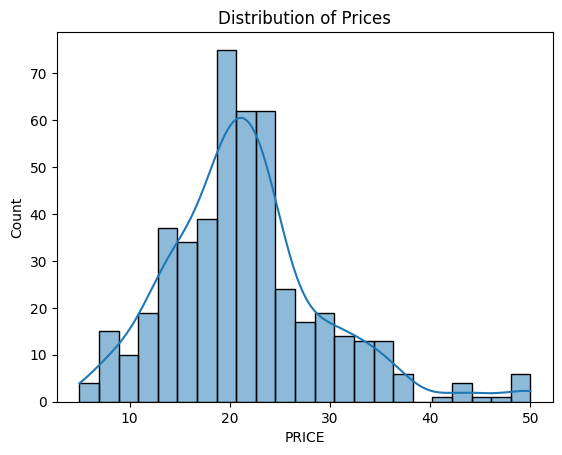

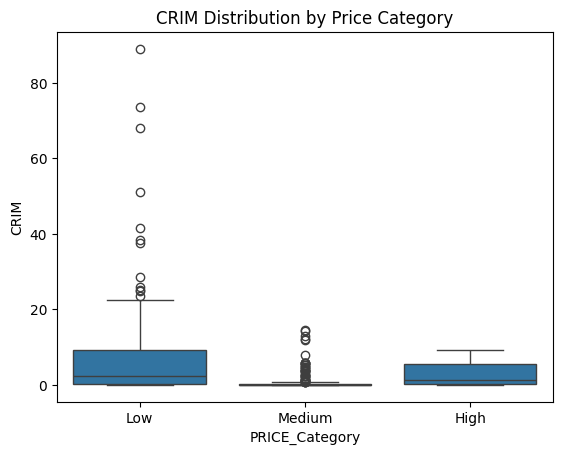

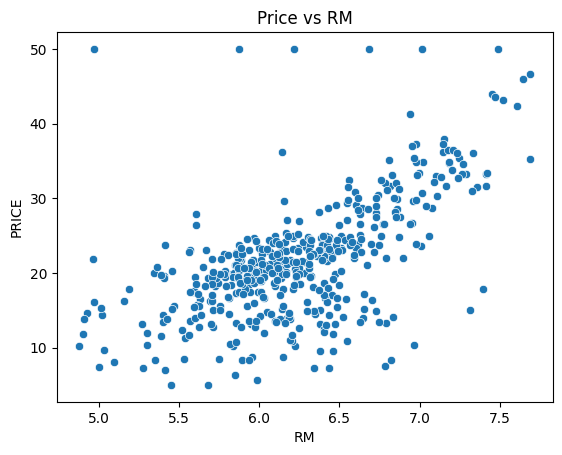

In [11]:
# 1. 绘制房价分布
sns.histplot(scaled_df['PRICE'], kde=True)
plt.title('Distribution of Prices')
plt.show()
# 2. 绘制每个房价分类的特征分布
sns.boxplot(x='PRICE_Category', y='CRIM', data=scaled_df)
plt.title('CRIM Distribution by Price Category')
plt.show()
# 3. 绘制房价与房间数量(RM)的关系
sns.scatterplot(x='RM', y='PRICE', data=scaled_df)
plt.title('Price vs RM')
plt.show()

## 2.8 实验完整步骤
1. 加载波士顿房价数据集：通过sklearn加载数据并将其转换为pandas DataFrame对象。
2. 数据清洗：处理缺失值、异常值，并进行标准化处理。
3. 特征工程：删除无关特征、将房价分为分类变量等。
4. 分组与聚合：使用`groupby`和`agg`分析数据。
5. 创建透视表：通过`pivot_table`查看不同特征之间的关系。
6. 优化筛选条件：根据数据的统计特性优化筛选条件，确保筛选结果有效。
7. 可视化：使用seaborn和matplotlib绘制图表进行数据可视化。

# 三、作业要求

1. 简述聚类算法的k的含义和作用。本实验中k表示什么？具体数值是几？
2. 简述提高聚类算法准确度的方法。
3. 尝试使用pandas的pivot_table进行更复杂的数据透视分析。(选做)

In [12]:
# 请在此处填写答案

# 四、实验总结
通过本次实验，我们深入学习了`pandas`库在数据分析中的多种功能，包括数据清洗、特征工程、分组聚合、数据合并和高级技巧。掌握了如何使用`pandas`进行复杂的数据分析任务，并通过可视化帮助我们理解数据的分布和特征之间的关系。